# Import Libraries

In [1]:
from scipy.stats import norm
from scipy.stats import lognorm
import numpy as np

import requests
import pandas as pd

import pathlib
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

from shapely.geometry import Point

import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import rioxarray
import xarray
from geocube.api.core import make_geocube

# Relevant Functionsm

## Functions to pull USGS Data

In [2]:
def get_elevation(lat, lon):
    """
    Get the elevation at a specific latitude and longitude coordinates.

    :param lat: The latitude of the location.
    :param lon: The longitude of the location.
    :return: The elevation in Feet.

    Example Usage:
    >>> get_elevation(37.7749, -122.4194)
    13.407

    """
    elevation_api_url = "https://epqs.nationalmap.gov/v1/json?"
    params = {
        'x': lon,
        'y': lat,
        'units': 'Feet',
        'wkid':4326,
        'includeDate':'false'
    }
    response = requests.get(elevation_api_url, params=params)
    elevation_data = response.json()
    return elevation_data['value']


def pull_data(bbox,
              start_date='1960-01-01T00:00', 
              end_date='2024-08-01T00:00', 
              site_status='all', 
              site_type='GW', 
              service='gwlevels',):
    """
    This method pulls groundwater level data from the U.S. Geological Survey (USGS) website.

    :param bbox: A string specifying the bounding box coordinates in the format "xmin,ymin,xmax,ymax" representing the geographic area to search for groundwater level data.
    :param start_date: A string specifying the start date of the data range in the format "YYYY-MM-DD".
    :param end_date: A string specifying the end date of the data range in the format "YYYY-MM-DD".
    :param site_status: A string specifying the status of the sites to include in the data. Possible values are "active", "inactive", or "all".
    :param site_type: A string specifying the type of sites to include in the data. Possible values are "well", "spring", or "all".
    :return: A JSON object containing the groundwater level data for the specified parameters.

    Example usage:
    ```
    bbox = "-95.7,29.6,-95.3,30.1"
    start_date = "2021-01-01"
    end_date = "2021-12-31"
    site_status = "active"
    site_type = "well"

    data = pull_data(bbox, start_date, end_date, site_status, site_type)
    print(data)
    ```
    """

    
    url = f"https://waterservices.usgs.gov/nwis/{service}"
    params = {
        'format': 'json',
        'bBox': bbox,
        'startDT': start_date,
        'endDT': end_date,
        'siteStatus': site_status,
        'siteType': site_type
    }
    response = requests.get(url, params=params)
    data = response.json()

    return data



def parse_data(data):
    """
    Parse data and return groundwater level data and site metadata.

    :param data: Dictionary containing weather data.
    :type data: dict
    :return: Tuple containing weather data and site metadata.
    :rtype: tuple
    """
    #data['value']['timeSeries'][0]['sourceInfo']['siteCode'][0]['value']
    df = {}
    sitemeta = {}
    
    for i,sitedata in enumerate(data['value']['timeSeries']):
        siteid = sitedata['sourceInfo']['siteCode'][0]['value']
        df[siteid] = pd.DataFrame(sitedata['values'][0]['value'])
        site_name = sitedata['sourceInfo']['siteName']
        lat = sitedata['sourceInfo']['geoLocation']['geogLocation']['latitude']
        lon = sitedata['sourceInfo']['geoLocation']['geogLocation']['longitude']
        srs = sitedata['sourceInfo']['geoLocation']['geogLocation']['srs']
        sitemeta[siteid] = pd.Series({'latitude': lat, 'longitude': lon, 'site_name': site_name,'srs': srs})
    
    site_data = pd.DataFrame(sitemeta).T
    wldata = pd.concat(df)
    wldata = wldata.droplevel(level=1)
    wldata.index.name = 'site_id'
    wldata['value'] = pd.to_numeric(wldata['value'], errors='coerce')
    wldata.replace(-999999, np.nan, inplace=True)
    site_data.index.name = 'site_id'
    wldata['dateTime'] = pd.to_datetime(wldata['dateTime']).dt.tz_localize(None)
    wldata = wldata.reset_index().set_index(['site_id','dateTime'])['value']
    return wldata, site_data


def add_site_metadata(site_data, wldata, siteid = 'site_id', value = 'value', date = 'dateTime'):
    allcounts = wldata.reset_index().groupby(siteid).count().sort_values([value],ascending=False)

    def dtrng(x):
        d = {}
        dtlist = sorted(x[date])
        d['first_date'] = dtlist[0]
        d['last_date'] = dtlist[-1]
        d['date_range'] = d['last_date'] - d['first_date']
        #print(d['first_date'],dtlist)
        return pd.Series(d, index=['first_date','last_date','date_range'])

    daterante = wldata.reset_index().groupby(siteid).apply(dtrng, include_groups=False)
    bigvals = allcounts[allcounts[value] >= 100]
    count_dict = allcounts[value].to_dict()
    #pahvant_well_sites_gdf = pahvant_well_sites_gdf.reset_index().set_index('site_no')
    site_data['totalmeasure'] = site_data.apply(lambda x: count_dict.get(str(x.name)),1)
    site_data['first_date'] = site_data.apply(lambda x: daterante.loc[str(x.name),'first_date'] if str(x.name) in daterante.index else None,1)
    site_data['last_date'] = site_data.apply(lambda x: daterante.loc[str(x.name),'last_date'] if str(x.name) in daterante.index else None,1)
    site_data['date_range'] = site_data.apply(lambda x: daterante.loc[str(x.name),'date_range'] if str(x.name) in daterante.index else None,1)
    site_data['date_range_days'] = site_data['date_range'].dt.days
    return site_data

def iterate_elevation(site_data):


    for site, row in site_data.iterrows():
        # Perform your desired operation on each row

        latitude = site_data.loc[site,'latitude']
        longitude = site_data.loc[site,'longitude']

        try:
            site_data.loc[site,'elevation'] = get_elevation(latitude, longitude)
        except:
            pass

        print(site)
        # Generate a random wait time between min_wait and max_wait
        #wait_time = random.uniform(1, 3)

        # Wait for the generated random time
        #time.sleep(wait_time/10)
    return site_data

# Set Paths

In [3]:
main_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley")
#main_path = pathlib.Path("H:/Pahvant/")
figure_dir = main_path / "Writing" / "Figures"
raw_dir = main_path / "Pahvant_Basins" / "Pahvant_Basins4"
save_place = main_path / "Pahvant_Basins" / "GEE_out" / "byhydrodiv"
gis_path = main_path / "GIS_Pahvant"

# USGS Data

## Import data

In [15]:
# Define the parameters for the API call
bbox = '-113.0,38.483695,-112.2,39.398000'
start_date = '1960-01-01'
end_date = '2024-07-01'
site_status = 'all'
site_type = 'GW'
elevation_api_url = 'https://nationalmap.gov/epqs/pqs.php'

gwdata = pull_data(bbox, service='gwlevels')
ivdata = pull_data(bbox, service='iv')
dvdata = pull_data(bbox, start_date=start_date, end_date=end_date, service='dv')
gw_wldata,gw_site_data = parse_data(gwdata)
iv_wldata,iv_site_data = parse_data(ivdata)
dv_wldata,dv_site_data = parse_data(dvdata)

#site_data = add_site_metadata(site_data, wldata, siteid = 'site_id', value = 'value', date = 'dateTime')    

In [16]:
wldata = pd.concat([gw_wldata.sort_index(),
                    iv_wldata.sort_index(),
                    dv_wldata.sort_index(),
                    ],
                   axis=0).sort_index().reset_index().drop_duplicates().set_index(['site_id','dateTime'])
site_data = pd.concat([gw_site_data.sort_index(),
                       iv_site_data.sort_index(),
                       dv_site_data.sort_index(),
                       ],
                      axis=0).sort_index().reset_index().drop_duplicates().set_index(['site_id'])   
site_data = add_site_metadata(site_data, wldata, siteid = 'site_id', value = 'value', date = 'dateTime')

In [76]:
wldata

value
site_id         dateTime                   
382924112592901 1977-08-08 12:00:00   16.40
                1977-10-01 12:00:00   13.06
                1978-03-09 12:00:00    7.58
                1978-10-03 12:00:00   12.60
                1979-03-08 12:00:00    7.78
...                                     ...
395532112213301 1985-08-14 19:15:00  113.96
                1985-09-09 19:15:00  114.26
                1985-10-16 19:15:00  114.66
                1985-12-12 12:00:00  115.21
                1986-01-15 12:00:00  115.90

[31987 rows x 1 columns]

## Georeference and project data

<Axes: >

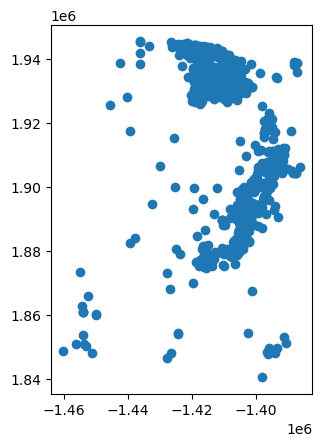

In [77]:
# Function to create a Point from latitude and longitude

def create_point(row):
    return Point(row['longitude'], row['latitude'])

# Create a geometry column by applying the function to each row
site_data['geometry'] = site_data.apply(create_point, axis=1)

# Convert the pandas DataFrame to a GeoDataFrame
site_gdf = gpd.GeoDataFrame(site_data, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
site_gdf.set_crs(epsg=4269, inplace=True)

sites_albers = site_gdf.to_crs(epsg=6350)

sites_albers['X'] = sites_albers.geometry.x
sites_albers['Y'] = sites_albers.geometry.y
sites_albers.plot()

## Filter by huc (using UGRC Service)

<Axes: >

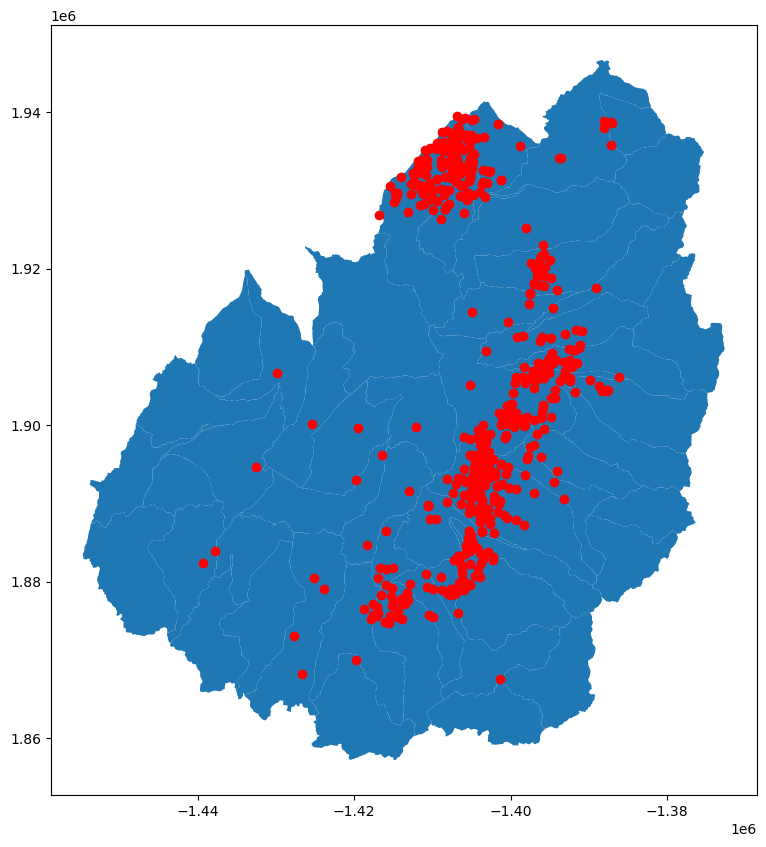

In [78]:
params = {'where':"HUC_10 in('1603000513','1603000514','1603000515','1603000801','1603000802','1603000803','1603000804','1603000805')",
          'units':'esriSRUnit_Meter','f':'pgeojson'}
#requests.utils.quote()
s = requests.Session()
p = requests.Request('GET',"https://services1.arcgis.com/99lidPhWCzftIe9K/ArcGIS/rest/services/UtahWatershedsArea/FeatureServer/0/query?",params = params).prepare()

watersheds = gpd.read_file(p.url)#.plot()

#gdb = "G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley/GIS_Pahvant/Pahvant/Pahvant.gdb"
#watersheds = geopandas.read_file(gdb, driver='FileGDB', layer='watersheds')
#hucs = [1603000513,1603000514,1603000515,1603000517,1603000801,1603000802,1603000803,1603000804,1603000805]

hydrodivs = gpd.read_file(gis_path / 'Valley_Hydrogeologic_Divisions.shp')
hydrodivs_wgs = hydrodivs.to_crs('epsg:4269')

watersheds = watersheds.to_crs(sites_albers.crs)
watersheds['dummy'] = 1
poly_sheds = watersheds.dissolve(by='dummy').loc[1, 'geometry']
pahvant_sites_gdf = sites_albers[sites_albers.within(poly_sheds)]

fig,ax =plt.subplots(1,1, figsize=(10,10))
watersheds.plot(ax=ax)
pahvant_sites_gdf.plot(ax=ax, color='red')

## Filter by month (Spring Data)

Filter data to only include spring data.  Group by year.

In [96]:
pvwldata = wldata[wldata.index.get_level_values(0).isin(pahvant_sites_gdf.index)]

sprwl = pvwldata[pvwldata.index.get_level_values(1).month.isin([2,3,4,5])]

countdf = sprwl.groupby(level=0).count()

spr_wls = sprwl[sprwl.index.get_level_values(0).isin(countdf[countdf>=30].index)]

flat_spr = spr_wls.unstack(level=0)
flat_spr.columns = [col[-1] for col in flat_spr.columns]
flat_spr['year'] = flat_spr.index.year        
spr_lump = flat_spr.groupby('year').mean()

## Bring In Auxiliary Pumping and Spring Flow data

In [103]:

#main_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley")
pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"

pumping = pd.read_excel(pumpdata,index_col='Year')
flow_cy = pd.read_parquet(main_path / "Flow Monitoring/clear_lake_spring_flow_cy.parquet")

comb_hydro = pd.concat([spr_lump,
                        flow_cy['ac-ft/yr'].sort_index(),
                        pumping['New_USGS'].sort_index()],axis=1)
comb_hydro = comb_hydro.sort_index().loc[1960:].dropna(axis=1, how='all')

## Impute missing groundwater levels

In [104]:

impute_estimator = BayesianRidge()

filled = IterativeImputer(random_state=0, estimator=impute_estimator, max_iter=60,).fit_transform(comb_hydro)



In [105]:
filled_data = pd.DataFrame(filled)
filled_data.index = comb_hydro.index
filled_data.columns = comb_hydro.columns
#filled_data.iloc[:,:-3].plot()

In [106]:
regionsites = []
for col in filled_data.columns:
    if col in pahvant_sites_gdf.index:
        regionsites.append(col)

print(len(regionsites))

411


## Use service to get elevations

In [107]:
pahvant_sites_gdf = iterate_elevation(pahvant_sites_gdf)

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


384253112384901
384428112341701
384451112211801
384519112400401
384722112315801
384722112322101
384722112333701
384741112330501
384743112333101
384747112305001
384748112315801
384751112312201
384755112330401
384801112342101
384815112280901
384815112312301
384815112331401
384821112283201
384824112333801
384829112315901
384848112305101
384850112310701
384850112381001
384852112260101
384856112310701
384856112315701
384906112303701
384906112305001
384906112330601
384907112311501
384909112491501
384910112321401
384931112391201
384935112305001
384935112305002
384946112321601
384953112325101
384956112265501
384959112271401
385003112263501
385007112482201
385011112283701
385012112274601
385013112291201
385014112304101
385015112333601
385021112270001
385023112270001
385026112261001
385026112264001
385028112260201
385053112252401
385053112252402
385053112253101
385053112262501
385055112330101
385055112333501
385105112280601
385105112292501
385107112260601
385107112261201
385107112323001
38513011

## Plot Points

C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_23236\1804197292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_wl_data['median_diff'] = pv_wl_data.diff(-1).median(axis=1)


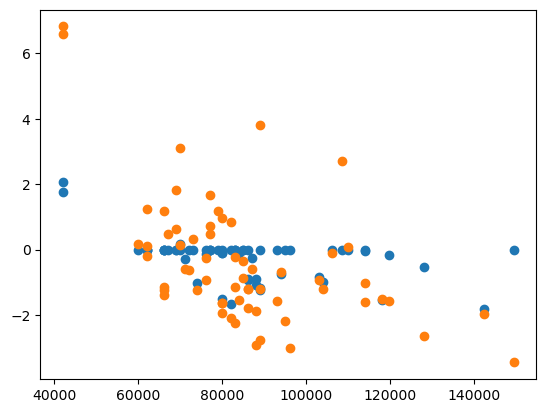

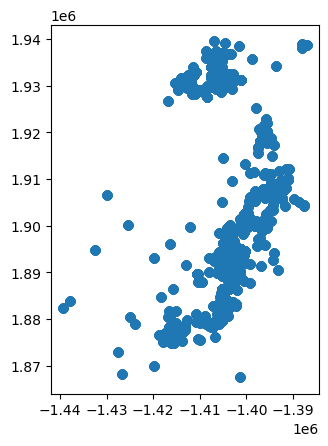

In [108]:
pv_wl_data = filled_data[regionsites]
pv_wl_data['median_diff'] = pv_wl_data.diff(-1).median(axis=1)
pv_wl_data['mean_diff'] = pv_wl_data.diff(-1).mean(axis=1)
pump_diff_wl = pd.concat([pv_wl_data[['mean_diff','median_diff']],pumping['New_USGS'].sort_index()],axis=1)
plt.scatter(pump_diff_wl['New_USGS'],pump_diff_wl['median_diff'])
plt.scatter(pump_diff_wl['New_USGS'],pump_diff_wl['mean_diff'])

stack_fill = pv_wl_data.stack().reset_index()
stack_fill.columns = ['year','site_id','value']
stack_fill.set_index(['year','site_id'],inplace=True)

loc_lev = pd.merge(pahvant_sites_gdf[['latitude','longitude','X','Y','elevation']],stack_fill, left_index=True, right_index=True)
loc_lev['wl_elev'] = loc_lev['elevation'] - loc_lev['value']

def create_alb_point(row):
    return Point(row['X'], row['Y'])

# Create a geometry column by applying the function to each row
loc_lev['geometry'] = loc_lev.apply(create_alb_point, axis=1)

# Convert the pandas DataFrame to a GeoDataFrame
loc_lev_gdf = gpd.GeoDataFrame(loc_lev, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
loc_lev_gdf.set_crs(epsg=5070, inplace=True)

loc_lev_gdf.plot()

loc_lev_gdf.to_file(gis_path / "usgs_wl_yearly_impute.geojson", driver='GeoJSON')

# Interpolate Values

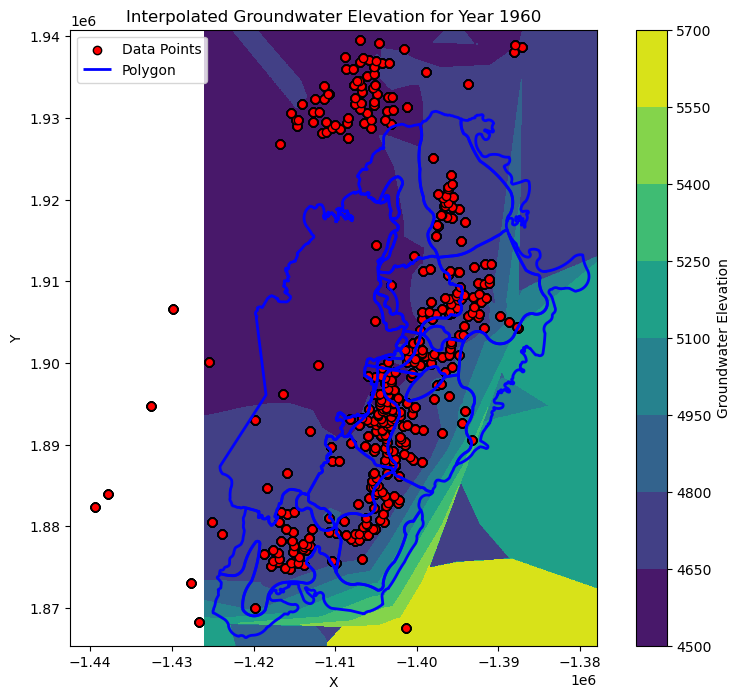

<xarray.DataArray (year: 65, x: 1000, y: 1000)> Size: 520MB
array([[[5159.91954298, 5159.91954298, 5159.91954298, ...,
         4634.07713835, 4634.07713835, 4634.07713835],
        [5159.91954298, 5159.91954298, 5159.91954298, ...,
         4634.07713835, 4634.07713835, 4634.07713835],
        [5159.91954298, 5159.91954298, 5159.91954298, ...,
         4634.07713835, 4634.07713835, 4634.07713835],
        ...,
        [5675.13241065, 5675.13241065, 5675.13241065, ...,
         4764.49345132, 4764.49345132, 4764.49345132],
        [5675.13241065, 5675.13241065, 5675.13241065, ...,
         4764.49345132, 4764.49345132, 4764.49345132],
        [5675.13241065, 5675.13241065, 5675.13241065, ...,
         4764.49345132, 4764.49345132, 4764.49345132]],

       [[5159.91954298, 5159.91954298, 5159.91954298, ...,
         4634.26983702, 4634.26983702, 4634.26983702],
        [5159.91954298, 5159.91954298, 5159.91954298, ...,
         4634.26983702, 4634.26983702, 4634.26983702],
        [5159

In [4]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator, griddata
from pykrige.uk import UniversalKriging
# Step 1: Load your data
loc_lev_gdf = gpd.read_file(gis_path / "usgs_wl_yearly_impute.geojson", driver='GeoJSON')
gdf = loc_lev_gdf.reset_index()



# Extract unique years from your data
years = gdf['year'].unique()

# Run the zonal statistics calculation
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
poly = poly.to_crs(5070)


# Step 2: Create a grid over your study area
x_min, y_min, x_max, y_max = poly.total_bounds
grid_x, grid_y = np.mgrid[x_min-1000:x_max+1000:1000j, y_min-1000:y_max+10000:1000j]  # Adjust the resolution as needed

# Step 3: Interpolate the groundwater elevations for each year
interpolated_values = []

# Define function for extrapolation using RegularGridInterpolator
# Define function for extrapolation using LinearNDInterpolator
def extrapolate(grid_x, grid_y, points, values):
    interpolator = LinearNDInterpolator(points, values, fill_value=np.nan)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    interpolated_values = interpolator(grid_points)

    # Replace NaNs with nearest values
    nearest_interpolator = griddata(points, values, grid_points, method='nearest')
    interpolated_values[np.isnan(interpolated_values)] = nearest_interpolator[np.isnan(interpolated_values)]

    return interpolated_values.reshape(grid_x.shape)


for year in years:
    # Filter data for the specific year
    yearly_data = gdf[gdf['year'] == year]
    points = np.array([yearly_data.geometry.x, yearly_data.geometry.y]).T
    values = yearly_data['wl_elev'].values

    # Interpolate and extrapolate the data
    grid_z = extrapolate(grid_x, grid_y, points, values)

    interpolated_values.append(grid_z)

# Step 4: Store the interpolated data into an xarray Dataset
interpolated_data = np.array(interpolated_values)
# Create an xarray Dataset
years = gdf['year'].unique()
xarray_data = xr.DataArray(interpolated_data, coords=[years, grid_x[:,0], grid_y[0,:]], dims=["year", "x", "y"])

# Set the CRS (additional step to ensure xarray knows about CRS, might require rioxarray)
import rioxarray
xarray_data.rio.write_crs(5070, inplace=True)

# Save or further process the xarray dataset
xarray_data.to_netcdf('interpolated_groundwater.nc')

# Optional: visualize the data for the first year
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, interpolated_data[0], cmap='viridis')
plt.colorbar(label='Groundwater Elevation')
plt.scatter(gdf.geometry.x, gdf.geometry.y, c='red', edgecolor='black', label='Data Points')

poly.boundary.plot(ax=plt.gca(), edgecolor='blue', linewidth=2, label='Polygon')
plt.title(f'Interpolated Groundwater Elevation for Year {years[0]}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

print(xarray_data)

## Statistic of all groundwater level changes over time

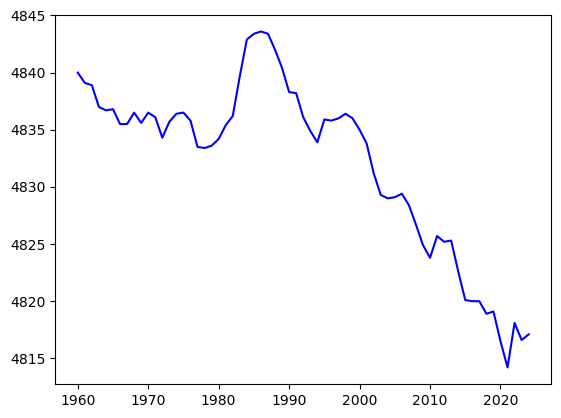

In [5]:
std_elev = {}
avg_elev = {}

for i,yr in enumerate(years):

    avg_elev[yr] = np.round(np.nanmean(interpolated_values[i], axis=None, out=None),1)
    std_elev[yr] = np.round(np.nanstd(interpolated_values[i], axis=None, out=None),1)
plt.plot(avg_elev.keys(), avg_elev.values(),color='blue')


## Calculate rasters of groundwater change over time

In [6]:

# Load the xarray dataset
ds = xr.open_dataset('interpolated_groundwater1.nc')

# Calculate the change in groundwater level between each year
diffs = ds['__xarray_dataarray_variable__'].diff(dim='year')

# Create a new xarray dataset for the changes
changes_ds = xr.Dataset(
    {
        'groundwater_level_change': (['year', 'y', 'x'], diffs.data)
    },
    coords={
        'year': diffs['year'].values,
        'x': ds['x'].values,
        'y': ds['y'].values
    }
)

# Set CRS attribute for the new xarray Dataset
changes_ds.attrs['crs'] = 'EPSG:5070'

# Save the new dataset to a NetCDF file
changes_ds.to_netcdf('groundwater_level_change.nc')

# Calculate Zonal Statistics

## Zonal Statistics of the 80s Confinement area

In [7]:

# Run the zonal statistics calculation
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/ 
#xarray_file = 'groundwater_level_change.nc'


# ensure the vector data are on the same grid as the stacked raster data
out_grid = make_geocube(vector_data=poly, measurements=["ID"], like=xarray_data)

# Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
out_grid["vals"] = (xarray_data.dims, xarray_data.values, xarray_data.attrs, xarray_data.encoding)
#grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
grouped_data = out_grid.drop_vars("spatial_ref").groupby(out_grid['ID'])
grid_mean = grouped_data.mean().rename({"vals": f"mean"})
#grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

zone_stat = xarray.merge([grid_mean]).to_dataframe()

zn = zone_stat.rename(index=dict(zip(list(range(0,65)),list(range(1960,2025)))),level=1)




## Zonal Statistic of the 2022 Aquifer Areas

In [8]:

# Run the zonal statistics calculation
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_now.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/ 
#xarray_file = 'groundwater_level_change.nc'


# ensure the vector data are on the same grid as the stacked raster data
out_grid = make_geocube(vector_data=poly, measurements=["ID"], like=xarray_data)

# Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
out_grid["vals"] = (xarray_data.dims, xarray_data.values, xarray_data.attrs, xarray_data.encoding)
#grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
grouped_data = out_grid.drop_vars("spatial_ref").groupby(out_grid['ID'])
grid_mean = grouped_data.mean().rename({"vals": f"mean"})
#grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

zone_stat = xarray.merge([grid_mean]).to_dataframe()

zn_new = zone_stat.rename(index=dict(zip(list(range(0,65)),list(range(1960,2025)))),level=1)

<Axes: xlabel='year'>

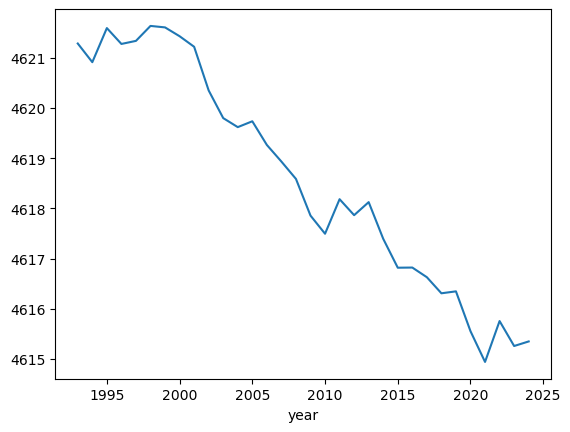

In [9]:
zn['diff'] = zn['mean'].diff()
zn.loc[1,'mean'].loc[1993:].plot()

In [10]:
def f(x):
    d = {}
    d['area'] = d['AREA'].sum()
    d['year'] = d['year'].mean()
    d['avg_wl'] = d['mean'].mean() 
    return pd.Series(d, index=d.keys())

polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/ 
poly_old = pd.merge(poly[['ID','WRarea','Bdrk_v_Valley','AREA']], zn.reset_index(), on='ID', how='left')
#xarray_file = 'groundwater_level_change.nc'

seds = poly_old[~poly_old['Bdrk_v_Valley'].isin(['Oak City Fm','Basalt'])]
total_area = seds.groupby('WRarea').sum(numeric_only=True)['AREA']

sub_areas_old = seds.groupby(['WRarea','Bdrk_v_Valley']).sum(numeric_only=True)#['AREA']

# Calculate Percent Area

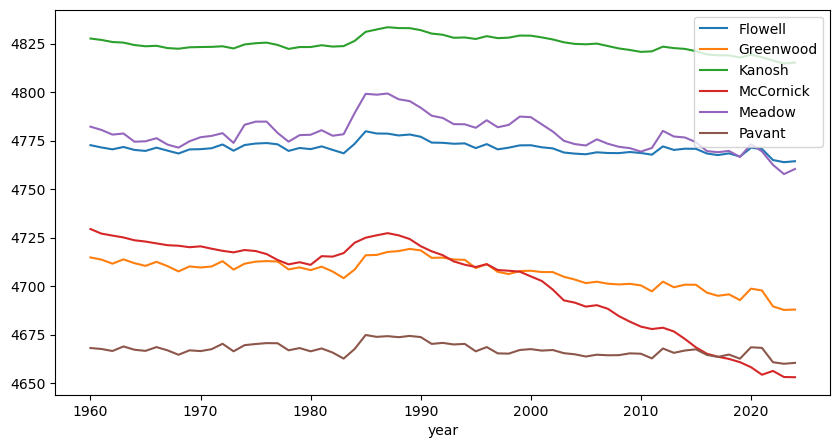

In [11]:
# Calculate Old Percent Areas 1987
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/ 
poly_old = pd.merge(poly[['ID','WRarea','Bdrk_v_Valley','AREA']], zn.reset_index(), on='ID', how='left')
#xarray_file = 'groundwater_level_change.nc'

seds = poly[~poly['Bdrk_v_Valley'].isin(['Oak City Fm','Basalt'])]
total_area = seds.groupby('WRarea').sum(numeric_only=True)['AREA']

sub_areas_old = seds.groupby(['WRarea','Bdrk_v_Valley']).sum(numeric_only=True)['AREA'].to_frame()
#pd.concat([sub_areas,total_area])#['percent_area'] = sub_areas['AREA']/total_area
sub_areas_old['total_area'] = sub_areas_old.index.get_level_values(0).map(total_area.to_dict())
sub_areas_old['high_percent'] = sub_areas_old['AREA'] / sub_areas_old['total_area']

# Calculate new percent areas 2022
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_now.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/
poly_new = pd.merge(poly[['ID','WRarea','Bdrk_v_Valley','AREA']], zn_new.reset_index(), on='ID', how='left')
#xarray_file = 'groundwater_level_change.nc'

seds = poly[~poly['Bdrk_v_Valley'].isin(['Oak City Fm','Basalt'])]
total_area = seds.groupby('WRarea').sum(numeric_only=True)['AREA']
sub_areas_new = seds.groupby(['WRarea','Bdrk_v_Valley']).sum(numeric_only=True)['AREA'].to_frame()
#pd.concat([sub_areas,total_area])#['percent_area'] = sub_areas['AREA']/total_area
sub_areas_new['total_area'] = sub_areas_new.index.get_level_values(0).map(total_area.to_dict())
sub_areas_new['low_percent'] = sub_areas_new['AREA'] / sub_areas_new['total_area']

# Combine Area data and unstack and rename
sub_areas = pd.concat([sub_areas_new['low_percent'],sub_areas_old['high_percent']],axis=1)
sub_areas = sub_areas.unstack(level=1)
sub_areas = sub_areas.replace(np.nan,0)
sub_areas.columns = ['unc_2022','con_2022','unc_1987','con_1987']
sub_areas = sub_areas[['unc_2022','unc_1987','con_2022','con_1987']]
sub_areas.loc[:,'total_area'] = sub_areas.index.map(total_area.to_dict())

poly_all = poly_new[~poly_new['Bdrk_v_Valley'].isin(['Oak City Fm','Basalt'])]
avg_area_gwl = poly_new.groupby(['WRarea','year']).mean(numeric_only=True)['mean']


fig, ax = plt.subplots(1,1,figsize=(10,5))

for region in avg_area_gwl.index.get_level_values(0).unique():
    avg_area_gwl.loc[region].plot(ax=ax, label=region)

ax.legend()

# Calcuate linear equation given two wls and two percent areas
for ind in sub_areas.index:
    sub_areas.loc[ind,'wl_2022'] = avg_area_gwl[ind].loc[2023]
    sub_areas.loc[ind,'wl_1987'] = avg_area_gwl[ind].loc[1987]

def calculate_linear_equation(row):
    xlow, xhigh = row['wl_2022'], row['wl_1987']
    ylow, yhigh = row['con_2022'], row['con_1987']
    # Calculate the slope (m)
    m = (yhigh - ylow) / (xhigh - xlow)
    # Calculate the intercept (c)
    c = ylow - m * xlow
    return m, c

# Apply the function to each row and store the results in new columns
sub_areas[['slope', 'intercept']] = sub_areas.apply(calculate_linear_equation, axis=1, result_type='expand')

perc_gwl = poly_new.groupby(['WRarea','year']).mean(numeric_only=True)['mean'].to_frame()

line_parms = sub_areas[['slope', 'intercept']].to_dict()

# find percents for each year and each area
for ind in perc_gwl.index.get_level_values(0).unique():
    for yr in perc_gwl.index.get_level_values(1).unique():
        #perc_gwl.loc[(ind,yr),'percent_unc'] = perc_gwl.loc[(ind,yr),'mean']*line_parms['slope'][ind] + line_parms['intercept'][ind]
        perc_gwl.loc[(ind,yr),'percent_con'] = perc_gwl.loc[(ind,yr),'mean']*line_parms['slope'][ind] + line_parms['intercept'][ind]


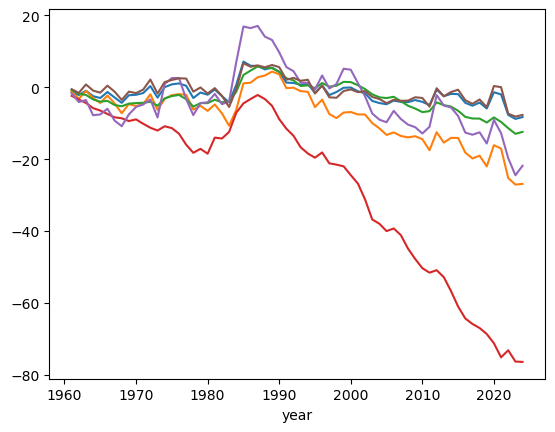

In [33]:
for ind in perc_gwl.index.get_level_values(0).unique():
    perc_gwl.loc[ind].loc[1961:,'dwl'].cumsum().plot(label=ind)

(1960.0, 2022.0)

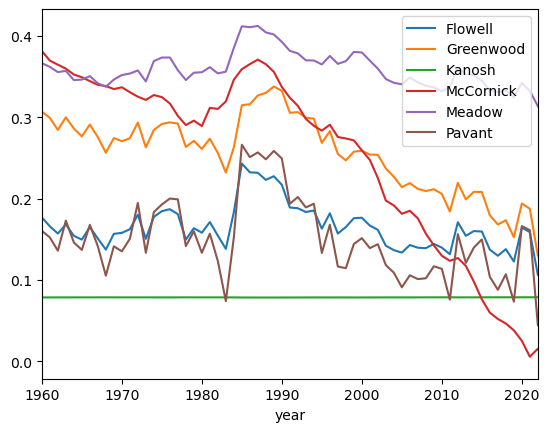

In [12]:
for ind in perc_gwl.index.get_level_values(0).unique():
    perc_gwl.loc[ind,'percent_con'].plot(label=ind)
plt.legend()
plt.xlim(1960,2022)

In [13]:
from scipy.stats import norm
from scipy.stats import lognorm
import numpy as np

Text(29.222222222222214, 0.5, 'Probability')

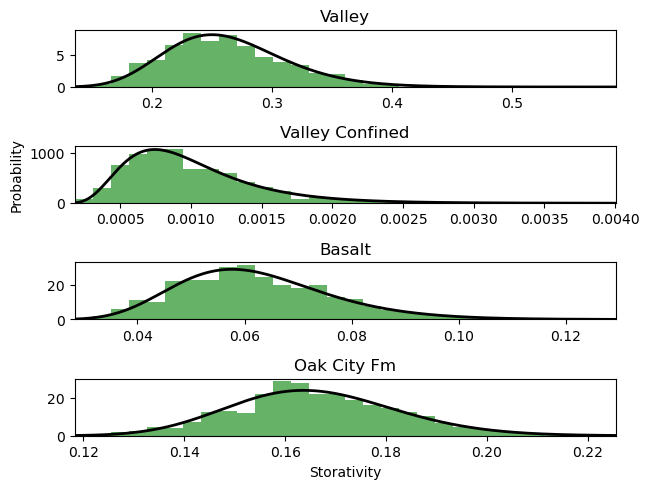

In [14]:

# Parameters for the underlying distribution
dist_params = {'Valley':[np.exp(-1.35),0.19],
               'Valley Confined':[np.exp(-7),0.45],
               'Basalt':[np.exp(-2.8),0.23],
               'Oak City Fm':[np.exp(-1.8),0.1],
               }

fig, ax = plt.subplots(4,1)

i = 0
for key,val in dist_params.items():
    # Create a lognormal distribution
    # scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
    dist = lognorm(s=val[1],scale=val[0])
    # Generate values from this distribution
    values = dist.rvs(size=1000)
    # Plot the histogram of the generated values
    ax[i].hist(values, bins=30, density=True, alpha=0.6, color='g')

    x = np.geomspace(min(values), max(values), 2000)
    # Plot the probability density function (PDF) of the lognormal distribution
    ax[i].plot(x, dist.pdf(x), 'k-', linewidth=2, label=key)
    ax[i].set_title(key)
    ax[i].set_xlim([min(values), max(values)])
    i += 1
plt.tight_layout()
ax[3].set_xlabel('Storativity')
ax[1].set_ylabel('Probability')
#plt.xscale('log')
#title = f"Fit results: mu = {mu:.2f}, sigma = {sigma:.2f}"
#lt.title(title)
#plt.show()

In [15]:
#poly['Bdrk_v_Valley']#.groupby('WRarea').sum()
perc_gwl['dwl'] = perc_gwl['mean'].diff()
perc_gwl = perc_gwl.replace(np.nan, 0)

poly['areacheck'] = poly.geometry.area
seds = poly[~poly['Bdrk_v_Valley'].isin(['Oak City Fm','Basalt'])]
oak_city = poly[poly['Bdrk_v_Valley'].isin(['Oak City Fm'])]
basalt = poly[poly['Bdrk_v_Valley'].isin(['Basalt'])]
total_area = seds.groupby('WRarea').sum(numeric_only=True)[['AREA','areacheck']]
total_area['acres'] = total_area['areacheck']*0.000247105

basalt_area = basalt['areacheck'].sum()*0.000247105
oak_city_area = oak_city['areacheck'].sum()*0.000247105

In [16]:
major_areas_by_geo = poly.groupby('Bdrk_v_Valley').sum(numeric_only=True)[['AREA','areacheck']]
major_areas_by_geo['area_acres'] = major_areas_by_geo['areacheck']*0.000247105
major_areas_by_geo

,AREA,areacheck,area_acres
Bdrk_v_Valley,,,
Basalt,752320000,4.554729e+08,112549.622361
Oak City Fm,398720000,2.413018e+08,59626.889047
Valley,1288160000,7.746048e+08,191408.728471
Valley Confined,152480000,9.123838e+07,22545.459613


In [17]:
major_areas_by_geo.loc['Basalt','area_acres']

112549.62236069025

In [43]:
# Parameters for the underlying distribution
dist_params = {'Valley':[np.exp(-2),0.25],
               'Valley Confined':[np.exp(-7),0.5],
               'Basalt':[np.exp(-2.8),0.25],
               'Oak City Fm':[np.exp(-3.9),0.1],
               }

aquifer_scale, aquifer_s = [{key : value[i] for key, value in dist_params.items()} for i in range(2)]

aquifer_s

{'Valley': 0.1353352832366127,
 'Valley Confined': 0.0009118819655545162,
 'Basalt': 0.06081006262521797,
 'Oak City Fm': 0.02024191144580439}

-56903.65755996088
-929299.5369733959


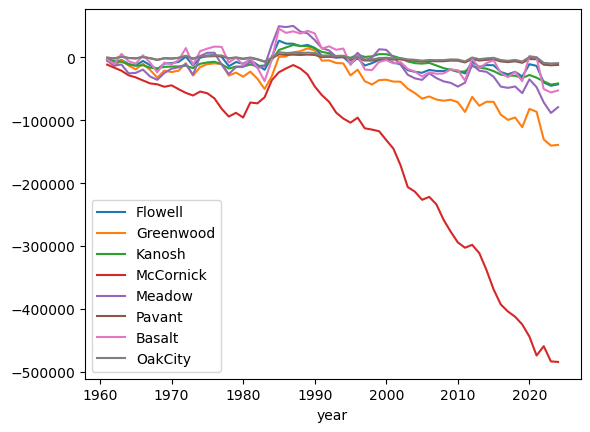

In [46]:
import scipy

# Parameters for the underlying distribution
#dist_params = {'Valley':[np.exp(-2),0.19],
#               'Valley Confined':[np.exp(-7),0.45],
#              'Basalt':[np.exp(-2.8),0.23],
#               'Oak City Fm':[np.exp(-2.5),0.1],
#               }

# Parameters for the underlying distribution
dist_params = {'Valley':[np.exp(-2),0.19],
               'Valley Confined':[np.exp(-7),0.45],
               'Basalt':[np.exp(-2.8),0.23],
               'Oak City Fm':[np.exp(-3.9),0.1],
               }



storativity_dist_uncon = lognorm(s=dist_params['Valley'][1],scale=dist_params['Valley'][0])
storativity_dist_con = lognorm(s=dist_params['Valley Confined'][1],scale=dist_params['Valley Confined'][0])
storativity_dist_bslt =lognorm(s=dist_params['Basalt'][1],scale=dist_params['Basalt'][0])
storativity_dist_ocfm = lognorm(s=dist_params['Oak City Fm'][1],scale=dist_params['Oak City Fm'][0])


bslt_area = major_areas_by_geo.loc['Basalt', 'area_acres']

ocfm_area = major_areas_by_geo.loc['Oak City Fm', 'area_acres']

storage_df = {}

for wrarea in perc_gwl.index.get_level_values(0).unique():
    for year in perc_gwl.index.get_level_values(1).unique():
        if year == 1960:
            pass
        else:
            totarea = total_area.loc[wrarea,'acres']
            df = perc_gwl.loc[wrarea].loc[year]  
            conarea = df['percent_con']*totarea
            unconarea = totarea - conarea
    
            # Create distributions
      
            # Sample from distributions
            samples = 10000  # Number of samples to draw
            
            con_storat = storativity_dist_con.rvs(samples)
            uncon_storat = storativity_dist_uncon.rvs(samples)
            gw_level_changes = norm(df['dwl'], np.abs(df['dwl'] * 0.05)).rvs(samples)
    
        
            # Calculate groundwater storage changes
            storage_changes = (conarea * gw_level_changes * con_storat) + (unconarea * gw_level_changes * uncon_storat)
            median = np.median(storage_changes)
            mean = np.mean(storage_changes)
            var = np.var(storage_changes)
            std = np.std(storage_changes)
            skew = scipy.stats.skew(storage_changes)
            kurtosis = scipy.stats.kurtosis(storage_changes)

    
            storage_df[f"{wrarea} {year}"] = pd.Series({'mean':mean,'median':median,"var":var,'std':std,'skew':skew,'kurtosis':kurtosis})

bslt_st = poly_new[poly_new['Bdrk_v_Valley'].isin(['Basalt'])].groupby('year').agg({'AREA':'sum','mean':'mean'})
ocfm_st = poly_new[poly_new['Bdrk_v_Valley'].isin(['Oak City Fm'])].groupby('year').agg({'AREA':'sum','mean':'mean'})



for year in range(1961,2025):
    totarea = total_area.loc[wrarea,'acres']
    df = perc_gwl.loc[wrarea].loc[year]

    # Create distributions

    # Sample from distributions
    samples = 10000  # Number of samples to draw

    bslt_storat = storativity_dist_bslt.rvs(samples)
    ocfm_storat = storativity_dist_ocfm.rvs(samples)
    gw_level_changes = norm(df['dwl'], np.abs(df['dwl'] * 0.05)).rvs(samples)


    # Calculate groundwater storage changes
    storage_changes = (bslt_area * gw_level_changes * bslt_storat) 
    median = np.median(storage_changes)
    mean = np.mean(storage_changes)
    var = np.var(storage_changes)
    std = np.std(storage_changes)
    skew = scipy.stats.skew(storage_changes)
    kurtosis = scipy.stats.kurtosis(storage_changes)

    storage_df[f"Basalt {year}"] = pd.Series({'mean':mean,'median':median,"var":var,'std':std,'skew':skew,'kurtosis':kurtosis})

    storage_changes = (ocfm_area * gw_level_changes * ocfm_storat)
    median = np.median(storage_changes)
    mean = np.mean(storage_changes)
    var = np.var(storage_changes)
    std = np.std(storage_changes)
    skew = scipy.stats.skew(storage_changes)
    kurtosis = scipy.stats.kurtosis(storage_changes)
    
    storage_df[f"OakCity {year}"] = pd.Series({'mean':mean,'median':median,"var":var,'std':std,'skew':skew,'kurtosis':kurtosis})


storage_change_vf = pd.DataFrame(storage_df).T
storage_change_vf.index.name='wrayr'
storage_change_vf.reset_index(inplace=True)
storage_change_vf[['wrarea','year']] = storage_change_vf['wrayr'].str.split(expand=True)
storage_change_vf['year'] = storage_change_vf['year'].astype(int)
storage_change_vf = storage_change_vf.set_index(['wrarea','year'])

for wrarea in storage_change_vf.index.get_level_values(0).unique():
    storage_change_vf.loc[wrarea,'median'].cumsum().plot(label=wrarea)

plt.legend()

med_by_area = storage_change_vf['median'].unstack(level=0)
med_by_area['all'] = med_by_area.sum(axis=1)
#med_by_area['all_cumsum'] = med_by_area.loc[1987:,'all'].cumsum()
print(med_by_area.loc[1987:,'all'].loc[2021])
print(med_by_area.loc[1987:,'all'].cumsum().loc[2022])

-24604.710397738058


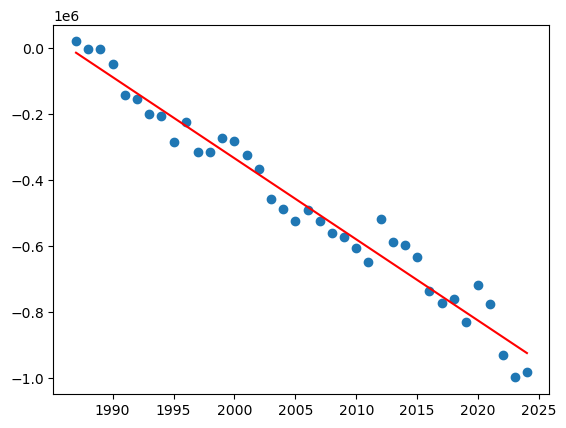

In [47]:
decline = med_by_area.loc[1987:,'all'].cumsum()
x = decline.index
y = decline
plt.scatter(x, y)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Create the regression line
regression_line = slope * x + intercept
# Plot the OLS regression line
plt.plot(x, regression_line, color='red', label='OLS Regression Line')
print(slope)

<Axes: xlabel='year'>

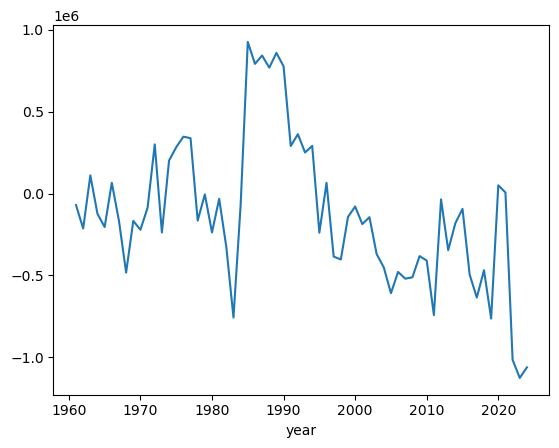

In [30]:
wrarea = 'Basalt'
storage_change_vf.loc[wrarea,'median'].cumsum().plot(label=wrarea)

In [25]:
dgwl_file = "C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/dGWL.gpkg"
dgwl60_22_file = "C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/dGWL_60_22.gpkg"

dgwl = gpd.read_file(dgwl_file)
dgwl60_22 = gpd.read_file(dgwl60_22_file)


aquifer_scale, aquifer_s = [{key : value[i] for key, value in dist_params.items()} for i in range(2)]

#dgwl.set_index('ID', inplace=True)

df_gwl = dgwl.groupby(['Bdrk_v_Valley']).sum(numeric_only=True)
df_gwl['s'] = df_gwl.index.get_level_values(0).map(aquifer_s)
df_gwl['scale'] = df_gwl.index.get_level_values(0).map(aquifer_scale)


storage_change_params = {}
storage_changes={}
storage_arrays = []
# Define the parameters for the distributions

storag_data = {}

for ind in df_gwl.index.get_level_values(0).unique():
    df = df_gwl.loc[ind]
    lithtype = ind
    aquifer_area = df['AREA']  # in square meters

    # Groundwater level change parameters (mean and standard deviation)
    gw_level_change_mean = df['MEAN'] * 0.3048  # in meters
    gw_level_change_std = np.abs(gw_level_change_mean * 0.10)  # in meters

    # Average storativity parameters (mean and standard deviation)
    storativity_mean = df['s']  # dimensionless
    storativity_std = df['scale']  # dimensionless

    # Create distributions
    gw_level_change_dist = norm(gw_level_change_mean, gw_level_change_std)
    storativity_dist = lognorm(s=storativity_mean, scale=storativity_std)

    # Sample from distributions
    samples = 10000  # Number of samples to draw
    gw_level_changes = gw_level_change_dist.rvs(samples)
    storativities = storativity_dist.rvs(samples)

    # Calculate groundwater storage changes
    storage_changes = aquifer_area * gw_level_changes * storativities * 0.000810714
    storage_arrays.append(storage_changes)
    median = np.median(storage_changes)
    mean = np.mean(storage_changes)
    var = np.var(storage_changes)
    std = np.std(storage_changes)
    skew = scipy.stats.skew(storage_changes)
    kurtosis = scipy.stats.kurtosis(storage_changes)
    
    storag_data[f"{lithtype}"] = pd.Series({'mean':mean,
                                                 'median':median,
                                                 "var":var,
                                                 'std':std,
                                                 'skew':skew,
                                                 'kurtosis':kurtosis})




s_change_vf = pd.DataFrame(storag_data).T
s_change_vf.index.name='lith'
#s_change_vf.reset_index(inplace=True)
#s_change_vf[['wrarea','lithtype']] = s_change_vf['wrayr'].str.split("_",expand=True)
#s_change_vf = s_change_vf.set_index(['wrarea','lithtype'])

#s_change_vf.groupby(level=1).describe()
s_change_vf

,mean,median,var,std,skew,kurtosis
lith,,,,,,
Basalt,1.569978e+05,1.524406e+05,1.588556e+09,3.985669e+04,0.746140,0.963934
Oak City Fm,2.367146e+06,2.348511e+06,1.122042e+11,3.349690e+05,0.324818,0.191582
Valley,2.148741e+07,2.101721e+07,2.190422e+13,4.680195e+06,0.699532,1.097156
Valley Confined,6.536507e+03,5.866397e+03,1.025286e+07,3.202008e+03,1.662616,5.631991


In [27]:
s_change_vf['mean'].sum()

24018093.51315464

In [30]:
med_by_area.loc[1987:,'all'].cumsum().loc[2022]

-12126503.407365166

In [26]:
s_change_vf['mean'].sum()/(2022-1988)

706414.5150927836

In [34]:
years_between_wl = 2022-1988
total_storage_change = np.sum(storage_arrays,axis=0)
print(f'total storage change {np.median(total_storage_change)}')
yearly_storage_change = total_storage_change/years_between_wl

years_between_wl = 2022-1986
years_between_wl_past = 2022-1960

storage_change_params = lognorm.fit(yearly_storage_change)
distribution = lognorm(*storage_change_params)
print(storage_change_params)
print(f"Yearly Storage Change {np.median(yearly_storage_change):0.2f} ac-ft")


sample_size = 5000
sample = distribution.rvs(size=sample_size)

# Compute the log of the sample
log_sample = np.log(sample)

# Calculate the parameters of the underlying normal distribution
mu = np.mean(log_sample)
sigma = np.std(log_sample)

# Calculate the standard deviation of the lognormal distribution
lognormal_std_dev = np.sqrt((np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2))

print(f"Estimated standard deviation of the lognormal distribution: {lognormal_std_dev}")


total storage change 23548875.361053154
(0.20880050689412366, 53918.62167381846, 638416.7424429718)
Yearly Storage Change 692613.98 ac-ft
Estimated standard deviation of the lognormal distribution: 135569.00200964833


# Sandbox

In [127]:
pvwldata.groupby(level=0).count()

,value
site_id,
384253112384901,3
384428112341701,2
384451112211801,1
384519112400401,5
384722112315801,252
...,...
392316112204001,13
392342112200201,373
392344112200701,1


6


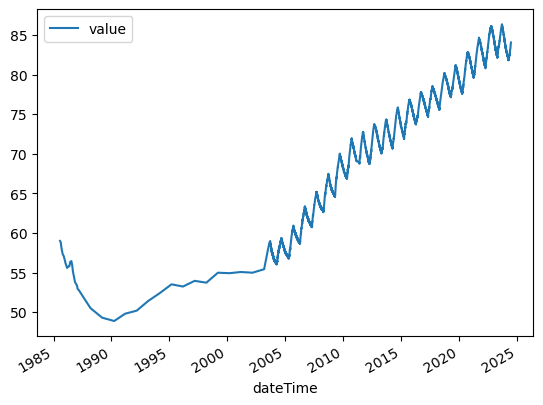

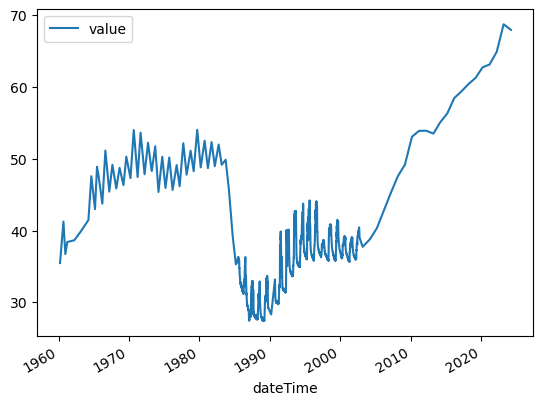

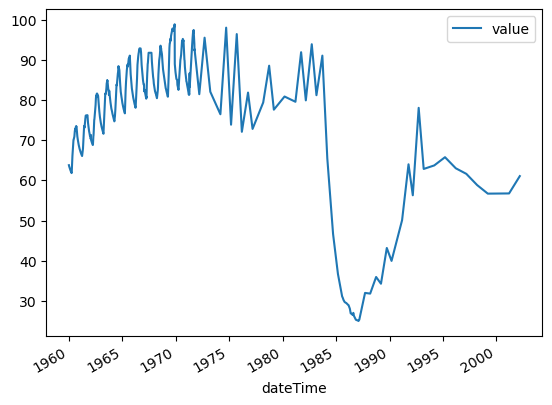

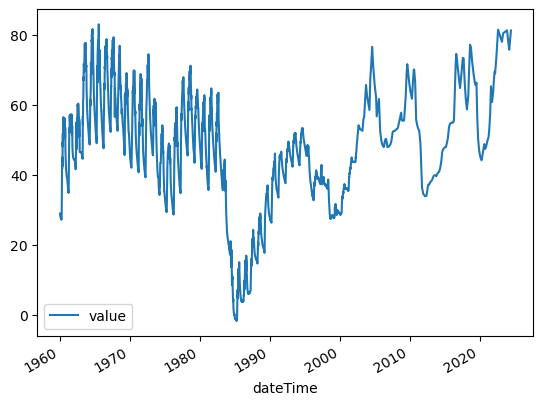

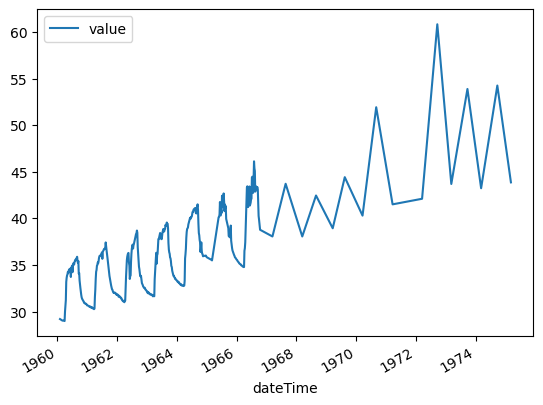

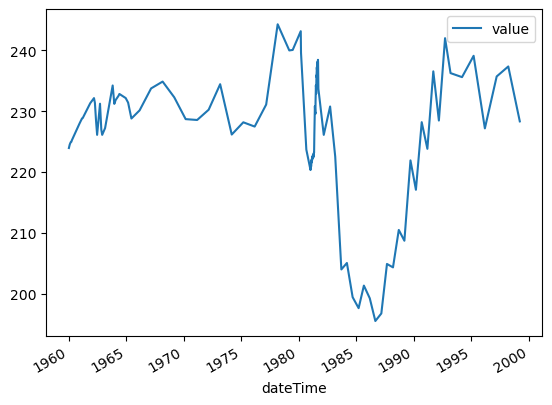

In [128]:
wlcounts = pvwldata.groupby(level=0).count()
print(len(wlcounts[wlcounts['value'] > 300].index))
many_wls = pvwldata[pvwldata.index.get_level_values(0).isin(wlcounts[wlcounts['value'] > 300].index)]
for well in many_wls.index.get_level_values(0).unique():
    many_wls.loc[well].plot()    

In [103]:
for ind in sub_areas.index:
    sub_areas.loc[ind,'wl_2022'] = avg_area_gwl[ind].loc[2022]
    sub_areas.loc[ind,'wl_1987'] = avg_area_gwl[ind].loc[1987]

sub_areas

,unc_2022,unc_1987,con_2022,con_1987,total_area,wl_2022,wl_1987
WRarea,,,,,,,
Flowell,0.903786,0.768131,0.096214,0.231869,257760000.0,NaN,NaN
Greenwood,0.882784,0.673084,0.117216,0.326916,305760000.0,NaN,NaN
Kanosh,0.921029,0.921406,0.078971,0.078594,180320000.0,NaN,NaN
McCornick,1.000000,0.629053,0.000000,0.370947,385600000.0,NaN,NaN
Meadow,0.698918,0.587644,0.301082,0.412356,251360000.0,NaN,NaN
Pavant,0.967914,0.743100,0.032086,0.256900,59840000.0,NaN,NaN
WRarea,NaN,NaN,NaN,NaN,NaN,4632.679971,4674.083034


In [102]:
sub_areas
#vg_area_gwl.loc['WRarea']

,unc_2022,unc_1987,con_2022,con_1987,total_area
WRarea,,,,,
Flowell,0.903786,0.768131,0.096214,0.231869,257760000
Greenwood,0.882784,0.673084,0.117216,0.326916,305760000
Kanosh,0.921029,0.921406,0.078971,0.078594,180320000
McCornick,1.000000,0.629053,0.000000,0.370947,385600000
Meadow,0.698918,0.587644,0.301082,0.412356,251360000
Pavant,0.967914,0.743100,0.032086,0.256900,59840000


In [77]:
#sub_areas
print(avg_elev[2022],np.min(list(avg_elev.values())))
print(avg_elev[1987],np.max(list(avg_elev.values())))


4668.7 4664.3
4720.8 4720.8


In [ ]:
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
#poly = poly.to_crs(6350)
poly = poly.to_crs(5070) #https://spatialreference.org/ref/sr-org/7301/ 
#xarray_file = 'groundwater_level_change.nc'

In [19]:


# ensure the vector data are on the same grid as the stacked raster data
out_grid_d = make_geocube(vector_data=poly, measurements=["ID"], like=changes_ds)

# Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
out_grid_d["vals"] = (changes_ds.dims, changes_ds.values, changes_ds.attrs, changes_ds.encoding)
#grouped_data = out_grid.drop("spatial_ref").groupby(out_grid['TARGET_FID'])
grouped_data_d = out_grid_d.drop_vars("spatial_ref").groupby(out_grid_d['ID'])
grid_mean_d = grouped_data_d.mean().rename({"vals": f"mean"})
#grid_std = grouped_data.std().rename({"vals": f"{varib}_std"})

zone_stat_d = xarray.merge([grid_mean_d]).to_dataframe()

zn_d = zone_stat_d.rename(index=dict(zip(list(range(0,65)),list(range(1960,2025)))),level=1)

ValueError: Variable 'vals': Could not convert tuple of form (dims, data[, attrs, encoding]): (FrozenMappingWarningOnValuesAccess({'year': 64, 'y': 1000, 'x': 1000}), <bound method Mapping.values of <xarray.Dataset> Size: 512MB
Dimensions:                   (year: 64, y: 1000, x: 1000)
Coordinates:
  * year                      (year) int64 512B 1961 1962 1963 ... 2023 2024
  * x                         (x) float64 8kB -1.426e+06 ... -1.378e+06
  * y                         (y) float64 8kB 1.865e+06 1.865e+06 ... 1.941e+06
Data variables:
    groundwater_level_change  (year, y, x) float64 512MB -3.54 -3.54 ... 3.863
Attributes:
    crs:      EPSG:5070>, {'crs': 'EPSG:5070'}, {}) to Variable.

In [27]:
out_grid_d

<xarray.Dataset> Size: 8MB
Dimensions:      (y: 1000, x: 1000)
Coordinates:
  * y            (y) float64 8kB 1.865e+06 1.865e+06 ... 1.941e+06 1.941e+06
  * x            (x) float64 8kB -1.426e+06 -1.426e+06 ... -1.378e+06 -1.378e+06
    spatial_ref  int32 4B 0
Data variables:
    ID           (y, x) float64 8MB nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
zone_stat

In [ ]:

poly.plot()

In [ ]:
sprwl = pvwldata[pvwldata.index.get_level_values(1).month.isin([2,3,4,5])]

countdf = sprwl.groupby(level=0).count()

spr_wls = sprwl[sprwl.index.get_level_values(0).isin(countdf[countdf>=30].index)]

flat_spr = spr_wls.unstack(level=0)
flat_spr['year'] = flat_spr.index.year
spr_lump = flat_spr.groupby('year').mean()

In [ ]:

from xrspatial import zonal_stats

zonal_stats(zones=poly, values=dataset)

In [ ]:
valley = hydrodivs[(hydrodivs['Bdrk_v_Val']=='Valley')&(~hydrodivs['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]
basalt = hydrodivs[(hydrodivs['Bdrk_v_Val']=='Basalt')&(~hydrodivs['WRarea'].isin(['West Desert','Oasis','Clear Lake']))]

valley = valley.to_crs(pahvant_sites_gdf.crs)
valley['dummy'] = 1
valley_sheds = valley.dissolve(by='dummy').loc[1, 'geometry']
pahvant_valley_sites = pahvant_sites_gdf[pahvant_sites_gdf.within(valley_sheds)]

fig, ax = plt.subplots(1,1)

valley.plot(color='green',ax=ax)
basalt.plot(color='grey',ax=ax)
pahvant_valley_sites.plot(ax=ax)

pv_gwl_data = gwl_data[gwl_data.index.get_level_values(0).isin(pahvant_valley_sites.index)]

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load your data
polygons = gpd.read_file('your_polygons.geojson')
clay_layer_raster = 'your_clay_layer.tif'

# Step 2: Reproject the polygons to match the raster CRS
with rasterio.open(clay_layer_raster) as src:
    raster_crs = src.crs
    clay_layer_data = src.read(1)
    clay_layer_transform = src.transform

polygons = polygons.to_crs(raster_crs)

# Step 3: Rasterize the polygons
def rasterize_polygon(polygon, out_shape, transform):
    mask = geometry_mask([polygon], transform=transform, invert=True, out_shape=out_shape)
    return mask

# Step 4: Compare elevation values and calculate percentages
results = []

for idx, row in polygons.iterrows():
    polygon = row['geometry']

    # Create mask raster for the current polygon
    mask_raster = rasterize_polygon(polygon, clay_layer_data.shape, clay_layer_transform)

    # Mask the clay layer data with the polygon mask
    masked_clay_layer = np.where(mask_raster, clay_layer_data, np.nan)

    # Calculate the percentage of area above the clay layer elevation
    total_area = np.sum(mask_raster)
    above_clay_layer_area = np.sum(masked_clay_layer > 0)  # Adjust threshold as needed

    if total_area > 0:
        percentage_above_clay_layer = (above_clay_layer_area / total_area) * 100
    else:
        percentage_above_clay_layer = 0

    results.append({
        'polygon_id': row['id'],  # Adjust column name as needed
        'percentage_above_clay_layer': percentage_above_clay_layer
    })

# Convert results to a GeoDataFrame
results_gdf = gpd.GeoDataFrame(results)

# Step 5: Save results
results_gdf.to_file('percentage_above_clay_layer.geojson', driver='GeoJSON')

# Optional: Print results
print(results_gdf)

# Optional: Visualization for one polygon
plt.figure(figsize=(10, 8))
plt.imshow(mask_raster, cmap='gray', interpolation='none', alpha=0.5)
plt.imshow(masked_clay_layer, cmap='viridis', interpolation='none', alpha=0.5)
plt.colorbar(label='Clay Layer Elevation')
plt.title(f'Polygon ID: {row["id"]}')
plt.show()



In [ ]:
(dataset.x.min().values.item(),
 dataset.y.min().values.item(),
 dataset.x.max().values.item(),
 dataset.y.max().values.item())

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

gdf = wells

# Reproject to match the CRS of the xarray (assuming EPSG:6350)
gdf = gdf.to_crs(epsg=6350)

# Extract coordinates and clay elevation values
points = np.array([gdf.geometry.x, gdf.geometry.y]).T
values = gdf['clay_elev'].values

# Step 2: Define the bounding box for interpolation
# Step 2: Extract the bounding box from the dataset's coordinates
xmin = dataset['x'].min().item()
xmax = dataset['x'].max().item()
ymin = dataset['y'].min().item()
ymax = dataset['y'].max().item()

bbox = (xmin, ymin, xmax, ymax)

# Step 3: Create a grid over the bounding box
xmin, ymin, xmax, ymax = bbox
grid_x, grid_y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  # Adjust the resolution as needed

# Step 4: Interpolate the clay elevation values
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Step 5: Save the interpolated raster as a GeoTIFF
transform = from_origin(xmin, ymax, (xmax - xmin) / 100, (ymax - ymin) / 100)

with rasterio.open(
        'clay_elevation_bbox.tif',
        'w',
        driver='GTiff',
        height=grid_z.shape[0],
        width=grid_z.shape[1],
        count=1,
        dtype=grid_z.dtype,
        crs=gdf.crs,
        transform=transform
) as dst:
    dst.write(grid_z, 1)

# Optional: Plotting for visualization
plt.figure(figsize=(10, 8))
plt.imshow(grid_z, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='viridis')
plt.colorbar(label='Clay Elevation')
plt.scatter(gdf.geometry.x, gdf.geometry.y, c='red', marker='o')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Interpolated Clay Elevation over BBOX')
plt.show()

In [ ]:
pahvant_sites_gdf[pahvant_sites_gdf.index.isin(loc_lev.index.get_level_values(0).unique())].plot()
        

In [ ]:
import math
import scipy

def splt_flt(f):
    int_part = int(math.floor(f * 10 ** 0) / 10 ** 0)
    float_part = abs(f)%1
    return int_part, float_part

def days_hours_minutes(doy_float):
    days, day_frac = splt_flt(doy_float)
    hours, hour_frac = splt_flt(day_frac*24)
    minutes, minute_frac = splt_flt(hour_frac*24)
    return days,hours,minutes

def add_time(doy_float, end_date):
    days, hours, minutes = days_hours_minutes(doy_float)
    new_date = end_date + timedelta(days=days, hours=hours, minutes=minutes)
    return new_date

def add_time(doy_float,end_date):
    days,hours,minutes = days_hours_minutes(doy_float)
    new_date = pd.to_datetime(end_date) + pd.DateOffset(days=int(days),hours=hours,minutes=minutes)
    return new_date

def well_function(u):
    return scipy.special.exp1(u)

def theis(t, r=1000, Q=1000, T=5000, S=0.001):
    Qft = 192.50*Q
    u = r ** 2 * S / 4. / T / t
    s = Qft / 4. / np.pi / T * well_function(u)
    return s


def pump_and_recover(duration, r=100, Q=1500, T=5000, S=0.0001):

    s={0:0}
    d={0:0}

    #dt_tq = [pd.to_datetime(start_date)]

    #duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

    for i in np.arange(0.1,duration*10,0.1):
        s[round(i,1)] = theis(i,r,Q,T,S)
        #dt_tq.append(add_time(round(i,1),start_date))

    for key,val in s.items():
        if key <= duration:
            d[key] = s[key]

        else:
            new_time = round(key - duration,1)
            if new_time < 0.01:
                new_time = 0

            d[key] = -1*s[new_time] + val


            #df = pd.DataFrame({'datetime':dt_tq,'drawdown':d.values()}).set_index('datetime').sort_index().resample('1D').mean()
    return d




In [ ]:
import math
import scipy
#import datetime
from datetime import datetime
from datetime import timedelta

def splt_flt(f):
    int_part = int(math.floor(f * 10 ** 0) / 10 ** 0)
    float_part = abs(f)%1
    return int_part, float_part

def days_hours_minutes(doy_float):
    days, day_frac = splt_flt(doy_float)
    hours, hour_frac = splt_flt(day_frac*24)
    minutes, minute_frac = splt_flt(hour_frac*24)
    return days,hours,minutes

def add_time(doy_float, end_date):
    days, hours, minutes = days_hours_minutes(doy_float)
    new_date = datetime.strptime(end_date, '%m/%d/%Y') + timedelta(days=days, hours=hours, minutes=minutes)
    return new_date



#def add_time(doy_float,end_date):
#    days,hours,minutes = days_hours_minutes(doy_float)
#    new_date = pd.to_datetime(end_date) + pd.DateOffset(days=int(days),hours=hours,minutes=minutes)
#    return new_date

def well_function(u):
    return scipy.special.exp1(u)

def theis(t, r=1000, Q=1000, T=5000, S=0.001):
    Qft = 192.50*Q
    u = r ** 2 * S / 4. / T / t
    s = Qft / 4. / np.pi / T * well_function(u)
    return s


def pump_and_recover(duration, r=1000, Q=5000, T=5000, S=0.0001):

    s={0:0}
    d={0:0}

    #dt_tq = [pd.to_datetime(start_date)]

    #duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

    for i in np.arange(0.1,duration*10,0.1):
        s[round(i,1)] = theis(i,r,Q,T,S)
        #dt_tq.append(add_time(round(i,1),start_date))

    for key,val in s.items():
        if key <= duration:
            d[key] = s[key]

        else:
            new_time = round(key - duration,1)
            if new_time < 0.01:
                new_time = 0

            d[key] = -1*s[new_time] + val


            #df = pd.DataFrame({'datetime':dt_tq,'drawdown':d.values()}).set_index('datetime').sort_index().resample('1D').mean()
    return d



d = pump_and_recover(180)
ds = pump_and_recover(180,S=0.1)
d_ar = np.array(list(d.values()))
ds_ar = np.array(list(ds.values()))

dt = {}
dfs = {}

pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"
pumping = pd.read_excel(pumpdata,index_col='Year')

mult = pumping.loc[1985:,'New_USGS'].values


for j,date in enumerate(range(1985,2022)):
    print(date)
    dt[date] = []
    
    if date < 2000:
        stor = 0.0001
    else:
        stor = 0.1

    d = pump_and_recover(180, Q=mult[j]/1000, S=stor, )
        
    dt[date] = [add_time(i, f'4/1/{date}') for i in d.keys()]
    dfs[date] = pd.DataFrame({'date':dt[date], 's':d_ar*mult[j]}).set_index('date')
        
(pd.concat(dfs,axis=1).sum(axis=1)*-1).plot()

In [ ]:
import pandas as pd
import pathlib
main_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley")
flow_cy=pd.read_parquet(main_path / "Flow Monitoring/clear_lake_spring_flow_cy.parquet")
flow_cy.to_clipboard()

In [ ]:
(pd.concat(dfs,axis=1).sum(axis=1)*-1).plot()

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import exp1
from datetime import timedelta

def splt_flt(f):
    int_part = int(f)
    float_part = abs(f) % 1
    return int_part, float_part

def days_hours_minutes(doy_float):
    days, day_frac = splt_flt(doy_float)
    hours, hour_frac = splt_flt(day_frac * 24)
    minutes, _ = splt_flt(hour_frac * 60)
    return days, hours, minutes

def add_time(doy_float, end_date):
    days, hours, minutes = days_hours_minutes(doy_float)
    new_date = end_date + timedelta(days=days, hours=hours, minutes=minutes)
    return new_date

def theis(t, r=1000, Q=1000, T=5000, S=0.001):
    Qft = 192.50 * Q
    u = r ** 2 * S / (4 * T * t)
    s = Qft / (4 * np.pi * T) * exp1(u)
    return s

def pump_and_recover(duration, r=100, Q=1500, T=5000, S=0.0001):
    times = np.arange(0.1, duration * 10, 0.1)
    s = theis(times, r, Q, T, S)
    d = np.zeros_like(s)

    for i, key in enumerate(times):
        if key <= duration:
            d[i] = s[i]
        else:
            new_time = key - duration
            if new_time < 0.01:
                new_time = 0
            d[i] = -s[int(new_time * 10)] + s[i]

    return dict(zip(times, d))


d = pump_and_recover(180)
ds = pump_and_recover(180, S=0.1)
d_ar = np.array(list(d.values()))
ds_ar = np.array(list(ds.values()))

dt = {}
dfs = {}

pumping = pd.DataFrame({'New_USGS': np.random.random(39)})  # Dummy data for demonstration
mult = (pumping['New_USGS'] / pumping['New_USGS'].max() * 3).values
base_date = pd.to_datetime('4/1/1985')

for j, year in enumerate(range(1985, 2024)):
    print(year)
    end_date = base_date.replace(year=year)
    

    if year < 2000:
        dt[year] = [add_time(i, end_date) for i in d.keys()]
        dfs[year] = pd.DataFrame({'date': dt[year], 's': d_ar * mult[j]}).set_index('date')
    else:
        dt[year] = [add_time(i, end_date) for i in ds.keys()]
        dfs[year] = pd.DataFrame({'date': dt[year], 's': ds_ar * mult[j]}).set_index('date')




In [ ]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator, griddata
from pykrige.uk import UniversalKriging
# Step 1: Load your data

loc_lev_gdf = gpd.read_file(gis_path / "usgs_wl_yearly_impute.geojson", driver='GeoJSON')
gdf = loc_lev_gdf.reset_index()

# Extract unique years from your data
years = gdf['year'].unique()

# Run the zonal statistics calculation
polygon_file = 'H:/Pahvant/Pahvant/GIS_Pahvant/Pahvant/Storage_Areas_80s.geojson'
poly = gpd.read_file(polygon_file)
poly = poly.to_crs(5070)


# Step 2: Create a grid over your study area
x_min, y_min, x_max, y_max = poly.total_bounds

grid_x = np.arange(x_min-1000, x_max+5000, 1000)
grid_y = np.arange(y_min-1000, y_max+5000, 1000)

# Step 3: Interpolate the groundwater elevations for each year
interpolated_values = []

# Define function for extrapolation using RegularGridInterpolator
# Define function for extrapolation using LinearNDInterpolator



for year in years[10:13]:
    # Filter data for the specific year
    yearly_data = gdf[gdf['year'] == year]
    points = np.array([yearly_data.geometry.x, yearly_data.geometry.y]).T
    values = yearly_data['wl_elev'].values
    UK = UniversalKriging(
        yearly_data.geometry.x, yearly_data.geometry.y, values,
        variogram_model="exponential",
        drift_terms=["regional_linear"],
    )
    # Interpolate and extrapolate the data
    z, ss = UK.execute("grid", grid_x, grid_y)
    plt.imshow(z)
    plt.show()
    interpolated_values.append(z)
    print(np.ndim(z))

# Step 4: Store the interpolated data into an xarray Dataset
interpolated_data = np.array(interpolated_values)
# Create an xarray Dataset
years = gdf['year'].unique()
xarray_data = xr.DataArray(interpolated_data,
                           coords=[years, grid_x, grid_y],
                           dims=["year", "x", "y"])

# Set the CRS (additional step to ensure xarray knows about CRS, might require rioxarray)
import rioxarray
xarray_data.rio.write_crs(5070, inplace=True)

# Save or further process the xarray dataset
xarray_data.to_netcdf('interpolated_groundwater.nc')

# Optional: visualize the data for the first year
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, interpolated_data[0], cmap='viridis')
plt.colorbar(label='Groundwater Elevation')
plt.scatter(gdf.geometry.x, gdf.geometry.y, c='red', edgecolor='black', label='Data Points')

poly.boundary.plot(ax=plt.gca(), edgecolor='blue', linewidth=2, label='Polygon')
plt.title(f'Interpolated Groundwater Elevation for Year {years[0]}')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

print(xarray_data)